In [1]:
import pandas as pd
import pickle
import datetime as dt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

In [2]:
#from LogIn import LogIn
#kite = LogIn().return_kite_obj()

In [3]:
budget_df = pd.read_csv('budget.csv')

In [4]:
budget_df

,instrument,budget,return
0,NSE:UNIONBANK,400,0.02
1,NSE:DCBBANK,400,0.02
2,NSE:YESBANK,400,0.02
3,NSE:WIPRO,400,0.02
4,NSE:TATASTEEL,400,0.02
5,NSE:SBIN,400,0.02
6,NSE:PNB,400,0.02
7,NSE:ONGC,400,0.02
8,NSE:OIL,400,0.02
9,NSE:NTPC,400,0.02


# Inputs

In [5]:
from_date = '2017-01-01'
to_date = '2017-12-31'

In [6]:
leverage = 15
exit_time = dt.time(15, 10)

# Process

In [7]:
# Download data of all companies
download = False

if download:
    for instrument in budget_df.instrument.tolist():

        try:
            print('------------')
            print(instrument)
            instrument_token = kite.ohlc(instrument)[instrument]['instrument_token']
            data = kite.historical_data(instrument_token=instrument_token, from_date=from_date, to_date=to_date, interval='minute', continuous=False)
            data_df = pd.DataFrame(data)
            data_df.to_pickle('./data/{}_{}_{}.pkl'.format(instrument, from_date, to_date))

        except Exception as ex:
            print('Failed for {} : {}'.format(instrument, ex))

In [8]:
def get_clean_data(instrument, from_date, to_date):
    
    print(instrument)
    data_df = pd.read_pickle('./data/{}_{}_{}.pkl'.format(instrument, from_date, to_date))
    data_df.rename(columns={'date':'timestamp'}, inplace=True)
    data_df['date'] = data_df['timestamp'].dt.date
    data_df['day'] = data_df['timestamp'].dt.day_name()
    print(len(data_df))

    sanity_check = data_df.groupby('date').count().reset_index()
    incomplete_data_days = sanity_check[sanity_check['volume']<300]
    print(incomplete_data_days)

    data_df = data_df[~data_df['date'].isin(incomplete_data_days.date.tolist())]
    data_df['instrument'] = instrument
    print(len(data_df)/375)
    
    return data_df

In [9]:
header_list = ['instrument', 'high_prev', 'low_prev', 'open_today', 'condition', 'transaction_type', 'trade_number', 'level', 'budget', 'return', 'daily_khwab', 'actual_khwab', 'quantity', 'budget_required', 'price', 'trigger_price', 'squareoff', 'stoploss', 'order_id', 'timestamp', 'order_type', 'status', 'profit', 'pl_tag', 'flag', 'adhoora_khwab']


In [10]:
calculate = True

if calculate:
    
    all_trades = pd.DataFrame(columns=header_list)

    for instrument in budget_df.instrument.tolist():

        try:
            data_df = get_clean_data(instrument, from_date, to_date)

            for i in range(len(data_df.date.unique().tolist())-1):

                date_prev = data_df.date.unique().tolist()[i]
                data_prev = data_df[data_df['date']==date_prev]
                open_prev = data_prev.open.iloc[0]
                close_prev = data_prev.open.iloc[-1]
                high_prev = data_prev.high.max()
                low_prev = data_prev.low.min()

                date_today = data_df.date.unique().tolist()[i+1]
                data_today = data_df[data_df['date']==date_today]

                # Trim beyond exit time
                data_today = data_today[data_today['timestamp'].dt.time<exit_time]
                open_today = data_today.open.iloc[0]

                if (open_today > high_prev) & (open_today < 1.15 * high_prev):

                    condition = 'high'
                    transaction_type = 'buy'

                elif (open_today < low_prev) & (open_today > 0.85 * low_prev):

                    condition = 'low'
                    transaction_type = 'sell'

                else:

                    condition = None
                    transaction_type = None

                if condition is not None:

                    valid_trades = all_trades[(all_trades['instrument']==instrument) & (all_trades['condition']==condition) & (all_trades['status']=='complete')]
                    last_valid_trade = valid_trades[valid_trades['trade_number']==valid_trades['trade_number'].max()]

                    # Calculate trade number
                    if len(last_valid_trade):
                        trade_number = int(last_valid_trade['trade_number']) + 1
                    else:
                        trade_number = 1

                    # Calculate level
                    if len(last_valid_trade):
                        if float(last_valid_trade['pl_tag'])==1.0:
                            level = 1
                        else:
                            level = float(last_valid_trade['level']) + 1
                    else:
                        level = 1

                    # Calculate budget and return
                    if level==1:
                        budget = float(budget_df[budget_df['instrument']==instrument]['budget'])
                        return_ = float(budget_df[budget_df['instrument']==instrument]['return'])
                    else:
                        budget = float(last_valid_trade['budget'])
                        return_ = float(last_valid_trade['return'])

                    # Calculate daily khwab
                    if len(last_valid_trade):
                        if int(last_valid_trade['flag'])==1:
                            daily_khwab = round(0.5 * return_ * budget, 2)
                        elif int(last_valid_trade['flag'])==-1:
                            daily_khwab = round(return_ * budget, 2)
                        else:
                            daily_khwab = 0
                    else:
                        daily_khwab = round(0.5 * return_ * budget, 2)

                    # Calculate actual khwab
                    if len(last_valid_trade):
                        actual_khwab = max(round(float(last_valid_trade['adhoora_khwab']) + daily_khwab, 2), round(0.5 * return_ * budget, 2))
                    else:
                        actual_khwab = round(0.5 * return_ * budget, 2)

                    # Calculate quantity
                    if len(last_valid_trade):
                        if level==1:
                            quantity = int(round(actual_khwab/(0.5 * return_ * open_today)))
                        else:
                            quantity = int(round(actual_khwab/(0.5 * return_ * open_today)))
                    else:
                        quantity = int(round(actual_khwab/(0.5 * return_ * open_today)))

                    # Calculate budget required
                    budget_required = round(quantity * open_today, 2)

                    # Calculate price and trigger price
                    if condition=='high':
                        price = round(open_today + 0.05 * max(round(20 * 0.0010 * open_today), 2), 2)
                        trigger_price = round(open_today + 0.05 * max(round(20 * 0.0005 * open_today),1), 2)
                    else:
                        price = round(open_today - 0.05 * max(round(20 * 0.0010 * open_today), 2), 2)
                        trigger_price = round(open_today - 0.05 * max(round(20 * 0.0005 * open_today),1), 2)

                    # Calculate square off and stoploss
                    squareoff = round(0.5 * return_ * price, 1)
                    stoploss = round(return_ * price, 1)

                    # Calculate order_id, order_type
                    order_id = trade_number
                    order_type = 'SL'

                    # Calculate timestamp, status and profit
                    if transaction_type=='buy':

                        if data_today.high.max() < trigger_price:

                            timestamp = data_today.timestamp.iloc[0]
                            status = 'incomplete'
                            profit = 0

                        else:

                            status = 'complete'
                            for index, row in data_today.iterrows():

                                if row['high'] > price + squareoff:
                                    timestamp = row['timestamp']
                                    profit = round(squareoff * quantity, 2)
                                    break

                                elif row['low'] < price - stoploss:
                                    timestamp = row['timestamp']
                                    profit = round(-1 * stoploss * quantity, 2)
                                    break

                                else:
                                    timestamp = row['timestamp']
                                    profit = round((row['close']-price) * quantity, 2)

                    else:

                        if data_today.low.min() > trigger_price:
                            timestamp = data_today.timestamp.iloc[0]
                            status = 'incomplete'
                            profit = 0            

                        else:

                            status = 'complete'
                            for index, row in data_today.iterrows():

                                if row['low'] < price - squareoff:
                                    timestamp = row['timestamp']
                                    profit = round(squareoff * quantity, 2)
                                    break

                                elif row['high'] > price + stoploss:
                                    timestamp = row['timestamp']
                                    profit = round(-1 * stoploss * quantity, 2)
                                    break

                                else:
                                    timestamp = row['timestamp']
                                    profit = round((price - row['close']) * quantity, 2)

                    # Calculate P/L tag
                    pl_tag = round(round(float(profit), 2) / (float(squareoff) * float(quantity)), 1)

                    # Calculate flag
                    if (pl_tag>=1):
                        flag = 1
                    elif (pl_tag<=-2):
                        flag = -1
                    else:
                        flag = 0

                    # Calculate adhoora khwab
                    adhoora_khwab = round(float(actual_khwab) - profit, 2)

                    trades_today = pd.DataFrame(data={'instrument':[instrument], 
                                                      'high_prev':[high_prev], 
                                                      'low_prev':[low_prev], 
                                                      'open_today':[open_today], 
                                                      'condition':[condition], 
                                                      'transaction_type':[transaction_type], 
                                                      'trade_number':[trade_number], 
                                                      'level':[level], 
                                                      'budget':[budget], 
                                                      'return':[return_], 
                                                      'daily_khwab':[daily_khwab], 
                                                      'actual_khwab':[actual_khwab], 
                                                      'quantity':[quantity], 
                                                      'budget_required':[budget_required], 
                                                      'price':[price], 
                                                      'trigger_price':[trigger_price], 
                                                      'squareoff':[squareoff], 
                                                      'stoploss':[stoploss], 
                                                      'order_id':[order_id], 
                                                      'timestamp':[timestamp], 
                                                      'order_type':[order_type], 
                                                      'status':[status], 
                                                      'profit':[profit], 
                                                      'pl_tag':[pl_tag], 
                                                      'flag':[flag], 
                                                      'adhoora_khwab':[adhoora_khwab]
                                                     })

                    all_trades = all_trades.append(trades_today, ignore_index = True)
        except Exception as ex:
            print('Failed calculation for {} : {}'.format(instrument, ex))
            
    all_trades.to_pickle('all_trades_oneper_{}_{}.pkl'.format(from_date, to_date))
    
else:
    
    all_trades = pd.read_pickle('all_trades_oneper_{}_{}.pkl'.format(from_date, to_date))

NSE:UNIONBANK
92490
           date  close  timestamp  high  low  open  volume  day
128  2017-07-10    180        180   180  180   180     180  180
198  2017-10-19     60         60    60   60    60      60   60
246.0
NSE:DCBBANK
92490
           date  close  timestamp  high  low  open  volume  day
128  2017-07-10    180        180   180  180   180     180  180
198  2017-10-19     60         60    60   60    60      60   60
246.0
NSE:YESBANK
92490
           date  close  timestamp  high  low  open  volume  day
128  2017-07-10    180        180   180  180   180     180  180
198  2017-10-19     60         60    60   60    60      60   60
246.0
NSE:WIPRO
92490
           date  close  timestamp  high  low  open  volume  day
128  2017-07-10    180        180   180  180   180     180  180
198  2017-10-19     60         60    60   60    60      60   60
246.0
NSE:TATASTEEL
92490
           date  close  timestamp  high  low  open  volume  day
128  2017-07-10    180        180   180  180   180  

NSE:L&TFH
92490
           date  close  timestamp  high  low  open  volume  day
128  2017-07-10    180        180   180  180   180     180  180
198  2017-10-19     60         60    60   60    60      60   60
246.0
NSE:PFC
92490
           date  close  timestamp  high  low  open  volume  day
128  2017-07-10    180        180   180  180   180     180  180
198  2017-10-19     60         60    60   60    60      60   60
246.0
NSE:EQUITAS
92490
           date  close  timestamp  high  low  open  volume  day
128  2017-07-10    180        180   180  180   180     180  180
198  2017-10-19     60         60    60   60    60      60   60
246.0
NSE:TATAMOTORS
92490
           date  close  timestamp  high  low  open  volume  day
128  2017-07-10    180        180   180  180   180     180  180
198  2017-10-19     60         60    60   60    60      60   60
246.0
NSE:IOC
92490
           date  close  timestamp  high  low  open  volume  day
128  2017-07-10    180        180   180  180   180     180  1

# High Trades Analysis

In [11]:
high_trades = all_trades[(all_trades['condition']=='high') & (all_trades['status']=='complete')]

In [12]:
high_trades_loop = pd.DataFrame()
for instrument in high_trades.instrument.unique().tolist():
    instrument_high_trades = high_trades[high_trades['instrument']==instrument]
    instrument_high_trades_loop = instrument_high_trades[instrument_high_trades['trade_number']<=instrument_high_trades[instrument_high_trades['pl_tag']==1.0].trade_number.max()]
    high_trades_loop = high_trades_loop.append(instrument_high_trades_loop, ignore_index=True)
    

In [21]:
high_trades.head(50)

,instrument,high_prev,low_prev,open_today,condition,transaction_type,trade_number,level,budget,return,daily_khwab,actual_khwab,quantity,budget_required,price,trigger_price,squareoff,stoploss,order_id,timestamp,order_type,status,profit,pl_tag,flag,adhoora_khwab
1,NSE:UNIONBANK,139.40,137.30,139.70,high,buy,1,1,400.0,0.02,4.0,4.00,3,419.10,139.85,139.75,1.4,2.8,1,2017-01-25 15:09:00+05:30,SL,complete,4.20,1.0,1,-0.20
6,NSE:UNIONBANK,156.90,151.20,157.35,high,buy,2,1,400.0,0.02,4.0,4.00,3,472.05,157.50,157.45,1.6,3.2,2,2017-03-17 10:19:00+05:30,SL,complete,-9.60,-2.0,-1,13.60
8,NSE:UNIONBANK,150.50,147.10,151.60,high,buy,3,2,400.0,0.02,8.0,21.60,14,2122.40,151.75,151.70,1.5,3.0,3,2017-03-24 09:38:00+05:30,SL,complete,21.00,1.0,1,0.60
10,NSE:UNIONBANK,160.90,156.50,160.95,high,buy,4,1,400.0,0.02,4.0,4.60,3,482.85,161.10,161.05,1.6,3.2,4,2017-04-25 13:08:00+05:30,SL,complete,4.80,1.0,1,-0.20
11,NSE:UNIONBANK,192.20,181.00,192.40,high,buy,5,1,400.0,0.02,4.0,4.00,2,384.80,192.60,192.50,1.9,3.9,5,2017-05-05 11:02:00+05:30,SL,complete,3.80,1.0,1,0.20
15,NSE:UNIONBANK,158.60,154.00,159.00,high,buy,6,1,400.0,0.02,4.0,4.20,3,477.00,159.15,159.10,1.6,3.2,6,2017-06-02 12:23:00+05:30,SL,complete,4.80,1.0,1,-0.60
16,NSE:UNIONBANK,160.00,156.85,160.20,high,buy,7,1,400.0,0.02,4.0,4.00,2,320.40,160.35,160.30,1.6,3.2,7,2017-06-08 15:09:00+05:30,SL,complete,-6.40,-2.0,-1,10.40
18,NSE:UNIONBANK,146.90,140.50,147.35,high,buy,8,2,400.0,0.02,8.0,18.40,12,1768.20,147.50,147.40,1.5,3.0,8,2017-06-29 15:09:00+05:30,SL,complete,-30.00,-1.7,0,48.40
20,NSE:UNIONBANK,154.20,150.60,158.00,high,buy,9,3,400.0,0.02,0.0,48.40,31,4898.00,158.15,158.10,1.6,3.2,9,2017-07-11 13:18:00+05:30,SL,complete,-99.20,-2.0,-1,147.60
21,NSE:UNIONBANK,154.85,150.40,156.05,high,buy,10,4,400.0,0.02,8.0,155.60,100,15605.00,156.20,156.15,1.6,3.1,10,2017-07-13 12:31:00+05:30,SL,complete,-310.00,-1.9,0,465.60


In [22]:
high_trades[high_trades['budget_required']==high_trades['budget_required'].max()]

,instrument,high_prev,low_prev,open_today,condition,transaction_type,trade_number,level,budget,return,daily_khwab,actual_khwab,quantity,budget_required,price,trigger_price,squareoff,stoploss,order_id,timestamp,order_type,status,profit,pl_tag,flag,adhoora_khwab
605,NSE:COALINDIA,255.85,251.6,256.65,high,buy,13,11,400.0,0.02,0.0,4881.25,1902,488148.3,256.9,256.8,2.6,5.1,13,2017-09-11 10:30:00+05:30,SL,complete,4945.2,1.0,1,-63.95


In [23]:
high_trades[high_trades['instrument']=='NSE:COALINDIA']

,instrument,high_prev,low_prev,open_today,condition,transaction_type,trade_number,level,budget,return,daily_khwab,actual_khwab,quantity,budget_required,price,trigger_price,squareoff,stoploss,order_id,timestamp,order_type,status,profit,pl_tag,flag,adhoora_khwab
578,NSE:COALINDIA,323.60,318.25,324.00,high,buy,1,1,400.0,0.02,4.0,4.00,1,324.00,324.30,324.15,3.2,6.5,1,2017-02-10 15:09:00+05:30,SL,complete,-0.25,-0.1,0,4.25
580,NSE:COALINDIA,321.40,317.10,322.20,high,buy,2,2,400.0,0.02,0.0,4.25,1,322.20,322.50,322.35,3.2,6.4,2,2017-02-22 10:22:00+05:30,SL,complete,3.20,1.0,1,1.05
581,NSE:COALINDIA,324.40,320.60,325.00,high,buy,3,1,400.0,0.02,4.0,5.05,2,650.00,325.30,325.15,3.3,6.5,3,2017-03-06 15:09:00+05:30,SL,complete,-4.90,-0.7,0,9.95
583,NSE:COALINDIA,292.40,288.05,293.00,high,buy,4,2,400.0,0.02,0.0,9.95,3,879.00,293.30,293.15,2.9,5.9,4,2017-03-21 15:09:00+05:30,SL,complete,-3.60,-0.4,0,13.55
585,NSE:COALINDIA,296.90,292.55,298.00,high,buy,5,3,400.0,0.02,0.0,13.55,5,1490.00,298.30,298.15,3.0,6.0,5,2017-03-24 15:09:00+05:30,SL,complete,-1.50,-0.1,0,15.05
588,NSE:COALINDIA,295.25,291.00,296.05,high,buy,6,4,400.0,0.02,0.0,15.05,5,1480.25,296.35,296.20,3.0,5.9,6,2017-04-05 14:15:00+05:30,SL,complete,-29.50,-2.0,-1,44.55
592,NSE:COALINDIA,283.40,276.10,283.60,high,buy,7,5,400.0,0.02,8.0,52.55,19,5388.40,283.90,283.75,2.8,5.7,7,2017-04-20 14:39:00+05:30,SL,complete,-108.30,-2.0,-1,160.85
593,NSE:COALINDIA,278.90,277.15,279.25,high,buy,8,6,400.0,0.02,8.0,168.85,60,16755.00,279.55,279.40,2.8,5.6,8,2017-04-26 15:09:00+05:30,SL,complete,-156.00,-0.9,0,324.85
594,NSE:COALINDIA,280.20,275.55,280.75,high,buy,9,7,400.0,0.02,0.0,324.85,116,32567.00,281.05,280.90,2.8,5.6,9,2017-05-04 15:09:00+05:30,SL,complete,-81.20,-0.3,0,406.05
595,NSE:COALINDIA,281.60,279.00,282.40,high,buy,10,8,400.0,0.02,0.0,406.05,144,40665.60,282.70,282.55,2.8,5.7,10,2017-05-05 15:09:00+05:30,SL,complete,-554.40,-1.4,0,960.45


# Low Trades Analysis

In [14]:
low_trades = all_trades[(all_trades['condition']=='low') & (all_trades['status']=='complete')]

In [15]:
low_trades_loop = pd.DataFrame()
for instrument in low_trades.instrument.unique().tolist():
    instrument_low_trades = low_trades[low_trades['instrument']==instrument]
    instrument_low_trades_loop = instrument_low_trades[instrument_low_trades['trade_number']<=instrument_low_trades[instrument_low_trades['pl_tag']==1.0].trade_number.max()]
    low_trades_loop = low_trades_loop.append(instrument_low_trades_loop, ignore_index=True)
    

In [16]:
low_trades.head()

,instrument,high_prev,low_prev,open_today,condition,transaction_type,trade_number,level,budget,return,daily_khwab,actual_khwab,quantity,budget_required,price,trigger_price,squareoff,stoploss,order_id,timestamp,order_type,status,profit,pl_tag,flag,adhoora_khwab
0,NSE:UNIONBANK,141.05,135.15,134.5,low,sell,1,1,400.0,0.02,4.0,4.00,3,403.5,134.35,134.45,1.3,2.7,1,2017-01-23 09:48:00+05:30,SL,complete,-8.10,-2.1,-1,12.10
2,NSE:UNIONBANK,169.65,164.50,163.0,low,sell,2,2,400.0,0.02,8.0,20.10,12,1956.0,162.85,162.90,1.6,3.3,2,2017-02-09 09:15:00+05:30,SL,complete,19.20,1.0,1,0.90
3,NSE:UNIONBANK,144.15,141.10,141.0,low,sell,3,1,400.0,0.02,4.0,4.90,3,423.0,140.85,140.95,1.4,2.8,3,2017-02-20 15:09:00+05:30,SL,complete,-2.25,-0.5,0,7.15
4,NSE:UNIONBANK,148.00,143.90,143.7,low,sell,4,2,400.0,0.02,0.0,7.15,5,718.5,143.55,143.65,1.4,2.9,4,2017-02-27 10:11:00+05:30,SL,complete,7.00,1.0,1,0.15
7,NSE:UNIONBANK,158.90,151.80,150.2,low,sell,5,1,400.0,0.02,4.0,4.15,3,450.6,150.05,150.10,1.5,3.0,5,2017-03-22 14:26:00+05:30,SL,complete,4.50,1.0,1,-0.35


# Results

In [17]:
pd.DataFrame(data={'high':[len(high_trades),
                           len(high_trades_loop),
                           round(high_trades_loop.profit.sum(), 2), 
                           round(high_trades_loop.profit.sum()/budget_df.budget.sum() * 100, 2),
                           round(high_trades_loop.budget_required.max()), 
                           round(high_trades_loop.budget_required.max()/leverage)],
                   'low':[len(low_trades),
                          len(low_trades_loop),
                          round(low_trades_loop.profit.sum(), 2), 
                          round(low_trades_loop.profit.sum()/budget_df.budget.sum() * 100, 2),
                          round(low_trades_loop.budget_required.max()),
                          round(low_trades_loop.budget_required.max()/leverage)]
                   }, 
             index = ['total_trades', 'trades_considered', 'profit', 'perc_return', 'hightest_budget_required', 'hightest_margin_required'])

,high,low
total_trades,1544.00,716.00
trades_considered,1435.00,688.00
profit,5432.69,2477.51
perc_return,19.33,8.82
hightest_budget_required,488148.00,92160.00
hightest_margin_required,32543.00,6144.00


# Daily Margin Required Analysis

In [18]:
all_trades['date'] = all_trades['timestamp'].dt.date
all_trades['margin_required'] = all_trades['budget_required']/leverage
margins = all_trades.groupby('date').agg({'budget_required':sum, 'margin_required':sum, 'instrument':list}).reset_index()

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def stacked_bar(data, series_labels, category_labels=None, 
                show_values=False, value_format="{}", y_label=None, 
                grid=True, reverse=False):
    """Plots a stacked bar chart with the data and labels provided.

    Keyword arguments:
    data            -- 2-dimensional numpy array or nested list
                       containing data for each series in rows
    series_labels   -- list of series labels (these appear in
                       the legend)
    category_labels -- list of category labels (these appear
                       on the x-axis)
    show_values     -- If True then numeric value labels will 
                       be shown on each bar
    value_format    -- Format string for numeric value labels
                       (default is "{}")
    y_label         -- Label for y-axis (str)
    grid            -- If True display grid
    reverse         -- If True reverse the order that the
                       series are displayed (left-to-right
                       or right-to-left)
    """

    ny = len(data[0])
    ind = list(range(ny))

    axes = []
    cum_size = np.zeros(ny)

    data = np.array(data)

    if reverse:
        data = np.flip(data, axis=1)
        category_labels = reversed(category_labels)

    for i, row_data in enumerate(data):
        axes.append(plt.bar(ind, row_data, bottom=cum_size, 
                            label=series_labels[i]))
        cum_size += row_data

    if category_labels:
        plt.xticks(ind, category_labels, rotation='vertical')

    if y_label:
        plt.ylabel(y_label)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    if grid:
        plt.grid()

    if show_values:
        for axis in axes:
            for bar in axis:
                w, h = bar.get_width(), bar.get_height()
                plt.text(bar.get_x() + w/2, bar.get_y() + h/2, 
                         value_format.format(h), ha="center", 
                         va="center")

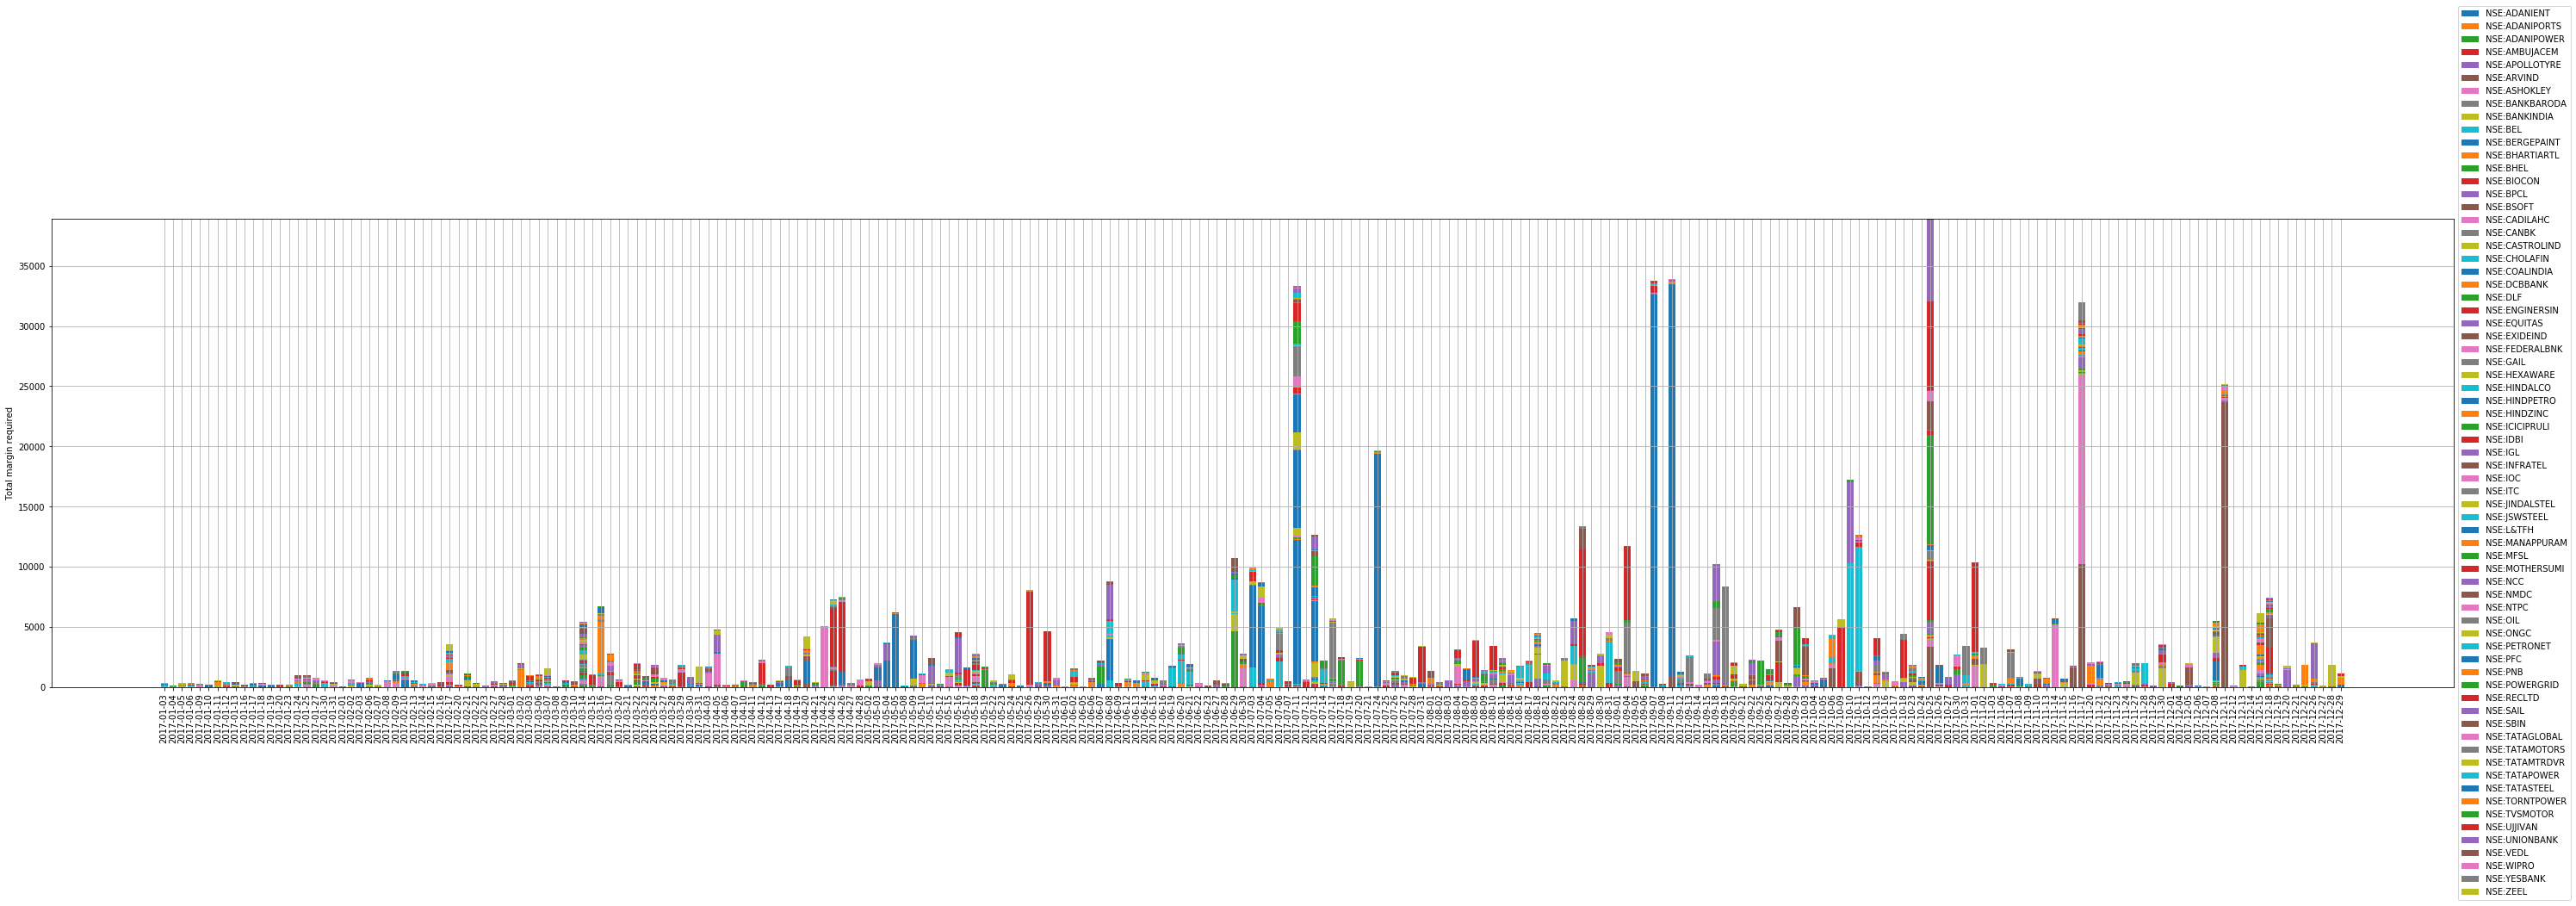

In [20]:
df2 = all_trades.groupby(['date', 'instrument'])['margin_required'].sum().unstack('instrument').fillna(0)

df = df2.transpose()

plt.figure(figsize=(50, 10))

series_labels = df.index.tolist()

data = df.values

category_labels = df.columns.tolist()

stacked_bar(
    data, 
    series_labels, 
    category_labels=category_labels, 
    show_values=False,
    value_format="{:.1f}",
    y_label="Total margin required"
)

plt.savefig('margin_required_oneper_{}_{}.png'.format(from_date, to_date))
plt.show()